In [ ]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [ ]:
# Lendo o arquivo
df = pd.read_csv( 'dados_chuva.csv', parse_dates=['Data'], index_col=['Data'])
df.head()

,precip,diario
Data,,
2000-01-01,1.0,3.0
2000-01-02,14.0,4.0
2000-01-03,26.0,NaN
2000-01-04,2.0,9.0
2000-01-05,3.0,4.0


In [ ]:
# Preenchendo vazios
df = df.fillna(0)

# Definindo variável para dias sem chuva
df['seca'] = df['diario'] == 0

# Agregando dado para dias sem precipitação por mês
d = df.resample('M')['seca'].sum()
d


Data
2000-01-31    17
2000-02-29    11
2000-03-31    15
2000-04-30    24
2000-05-31    31
              ..
2020-08-31    31
2020-09-30    29
2020-10-31    19
2020-11-30    10
2020-12-31    17
Freq: M, Name: seca, Length: 252, dtype: int64

In [ ]:
# Convertendo para dataframe 
d = pd.DataFrame(d)

In [ ]:
# Renomeando colunas para o padrão do prophet (obrigatório)
d.reset_index(inplace=True)
df = d[['Data', 'seca']]
df.columns = ['ds', 'y']

In [ ]:
# Instanciando modelo
m = Prophet()

# Ajustando o modelo aos dados
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Criando dataframe para as previsões (60 meses)
future = m.make_future_dataframe(60, freq='M')
future.head()

,ds
307,2025-08-31
308,2025-09-30
309,2025-10-31
310,2025-11-30
311,2025-12-31


In [ ]:
# Fazendo previsão
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
307,2025-08-31,29.973867,25.730425,34.250792
308,2025-09-30,26.161076,21.770250,30.651674
309,2025-10-31,20.111753,15.521760,24.424216
310,2025-11-30,12.368454,8.264440,17.141723
311,2025-12-31,12.562130,7.887424,16.953407


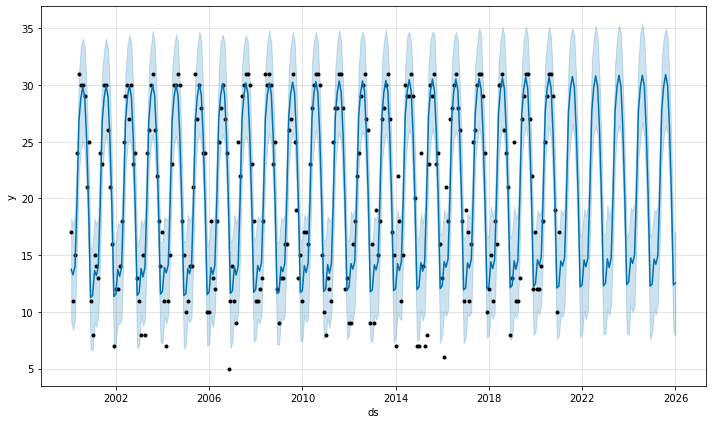

In [ ]:
# Visualizando previsão (dados originais em preto)
fig1 = m.plot(forecast)

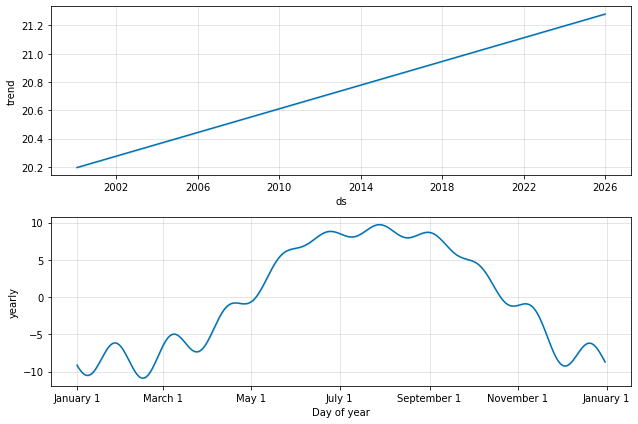

In [ ]:
# Componentes (caso fosse uma previsão diária teríamos a componente para os dias tbm)
fig2 = m.plot_components(forecast)

In [ ]:
# Calculando cross-validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 37 forecasts with cutoffs between 2002-04-05 00:00:00 and 2020-01-01 00:00:00


  0%|          | 0/37 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [ ]:
# Calculando erro
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,25.689865,5.068517,3.494858,0.187320,0.083630,0.681818
1,38 days,26.797637,5.176643,3.638406,0.193689,0.089739,0.659091
2,40 days,25.385504,5.038403,3.611799,0.192553,0.096014,0.636364
3,41 days,25.221114,5.022063,3.564285,0.190783,0.089739,0.636364
4,42 days,24.926639,4.992659,3.525763,0.189714,0.089739,0.659091


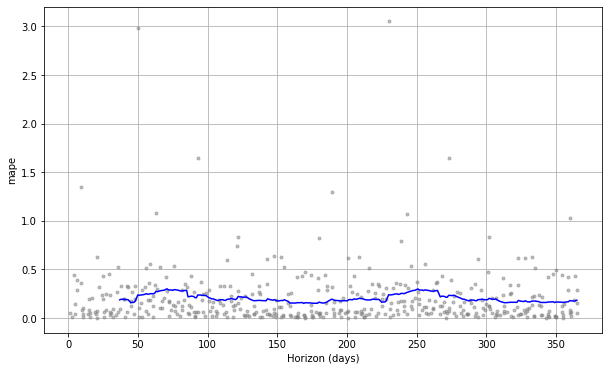

In [ ]:
# Visualizando distribuição do erro MAPE
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')